In [13]:
# -----------------------------------------------------------------------------
# Copyright (c) 2022, Lucid Vision Labs, Inc.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
# OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
# BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
# ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.
# -----------------------------------------------------------------------------

In [1]:
import time

import numpy as np # pip3 install numpy
import cv2  # pip3 install opencv-python
from matplotlib import pyplot as plt # pip3 install matplotlib
# pip3 install pillow
from PIL import Image as PIL_Image
from PIL import ImageTk as PIL_ImageTk
# pip3 install tk / or 'sudo apt-get install python3-tk' for linux
from tkinter import *

from arena_api import enums
from arena_api.system import system
from arena_api.buffer import BufferFactory

In [15]:
'''
Acquisition: Introduction
	This example introduces the basics of image acquisition. This
	includes setting image acquisition and buffer handling modes,
	setting the device to automatically negotiate packet size, and
	setting the stream packet resend node before starting the image
	stream. The example then acquires an image by grabbing and
	requeuing a single buffer and retrieving its data, before stopping
	the stream. It then displays the image using Matplotlib, OpenCV and Tkinter.
'''

'\nAcquisition: Introduction\n\tThis example introduces the basics of image acquisition. This\n\tincludes setting image acquisition and buffer handling modes,\n\tsetting the device to automatically negotiate packet size, and\n\tsetting the stream packet resend node before starting the image\n\tstream. The example then acquires an image by grabbing and\n\trequeuing a single buffer and retrieving its data, before stopping\n\tthe stream. It then displays the image using OpenCV.\n'

In [2]:
"""
Waits for the user to connect a device before raising an exception if it fails
"""
tries = 0
tries_max = 6
sleep_time_secs = 10
devices = None
while tries < tries_max:  # Wait for device for 60 seconds
    devices = system.create_device()
    if not devices:
        print(
            f'Try {tries+1} of {tries_max}: waiting for {sleep_time_secs} '
            f'secs for a device to be connected!')
        for sec_count in range(sleep_time_secs):
            time.sleep(1)
            print(f'{sec_count + 1 } seconds passed ',
                    '.' * sec_count, end='\r')
        tries += 1
    else:
        print(f'Created {len(devices)} device(s)')
        break
else:
    raise Exception(f'No device found! Please connect a device and run '
                    f'the example again.')

device = devices[0]
nodemap = device.nodemap
print(f'Device used in the example:\n\t{device}')

Try 1 of 6: waiting for 10 secs for a device to be connected!
Try 2 of 6: waiting for 10 secs for a device to be connected!
Try 3 of 6: waiting for 10 secs for a device to be connected!
Created 1 device(s).........
Device used in the example:
	('1c:0f:af:11:22:33', 'TRI054S-C', '', '10.0.0.56')


In [3]:
"""
Store initial node values, return their values at the end of example
"""
nodes = device.nodemap.get_node(['Width', 'Height', 'PixelFormat'])
width_initial = nodes['Width'].value
height_initial = nodes['Height'].value
pixel_format_initial = nodes['PixelFormat'].value

In [4]:
"""
Setup features before streaming
"""
# Get stream nodemap
stream_nodemap = device.tl_stream_nodemap

# Enable stream auto negotiate packet size
stream_nodemap['StreamAutoNegotiatePacketSize'].value = True

# Enable stream packet resend
stream_nodemap['StreamPacketResendEnable'].value = True

# Set width and height to their max values
print('Setting \'Width\' and \'Height\' Nodes value to their max values')
nodes['Width'].value = nodes['Width'].max
nodes['Height'].value = nodes['Height'].max

# Setting pixel format 
new_pixel_format = 'Mono8'
print(f'Setting \'PixelFormat\' to \'{new_pixel_format}\'')
nodes['PixelFormat'].value = new_pixel_format

Setting 'Width' and 'Height' Nodes value to their max values
Setting 'PixelFormat' to 'Mono8'


In [5]:
"""
Convert to BGR8 format, which allows images to be easily
displayed using matplotlib and opencv-python
"""

def convert_buffer_to_BGR8(buffer):

    if (buffer.pixel_format == enums.PixelFormat.BGR8):
        return buffer
    print('Converting image buffer pixel format to BGR8 ')
    return BufferFactory.convert(buffer, enums.PixelFormat.BGR8)


In [20]:
"""
demonstrates acquisition
 (1) sets acquisition mode
 (2) sets buffer handling mode
 (3) enables auto negotiate packet size
 (4) enables packet resend
 (5) starts the stream
 (6) gets a number of images
 (7) prints information from images
 (8) requeues buffers
 (9) stops the stream
"""

'\ndemonstrates acquisition\n (1) sets acquisition mode\n (2) sets buffer handling mode\n (3) enables auto negotiate packet size\n (4) enables packet resend\n (5) starts the stream\n (6) gets a number of images\n (7) prints information from images\n (8) requeues buffers\n (9) stops the stream\n'

In [6]:
"""
Starting the stream allocates buffers, which can be passed in as
an argument (default: 10), and begins filling them with data.
For this case, we will be passing 1 as the argument, as we only need 1 buffer.
Buffers must later be requeued to avoid memory leaks.
"""
buffer_BGR8 = None
np_array_reshaped = None

with device.start_stream(1):
    print(f'Stream started with 1 buffers')
    
    """
    'device.get_buffer()' with no arguments returns only one buffer
    # the buffer is in the rgb layout
    """
    print('\tGet one buffer')
    
    buffer = device.get_buffer()

    # Print some info about the image in the buffer
    print(f'\t\tbuffer received   | '
        f'Width = {buffer.width} pxl, '
        f'Height = {buffer.height} pxl, '
        f'Pixel Format = {buffer.pixel_format.name}')

    # Converting to BGR8 format
    print('\tConverting to BGR8 format')
    buffer_BGR8 = convert_buffer_to_BGR8(buffer)

    # Requeue to release buffer memory
    print('Requeuing device buffer')
    device.requeue_buffer(buffer)

    # Get a copy so it can be used after the buffer is requeued
    print('\tConvert image buffer to a numpy array')
    buffer_bytes_per_pixel = int(len(buffer_BGR8.data)/(buffer_BGR8.width * buffer_BGR8.height))
    np_array = np.asarray(buffer_BGR8.data, dtype=np.uint8)
    np_array_reshaped = np_array.reshape(buffer_BGR8.height, buffer_BGR8.width, buffer_bytes_per_pixel)

Stream started with 1 buffers
	Get one buffer
		buffer received   | Width = 2880 pxl, Height = 1860 pxl, Pixel Format = Mono8
	Converting to BGR8 format
Converting image buffer pixel format to BGR8 
Requeuing device buffer
	Convert image buffer to a numpy array


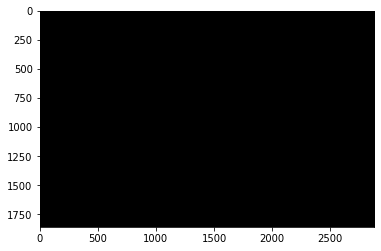

In [10]:
'''
Display image in the correct format for matplot
'''
np_array_shaped_rgb = cv2.cvtColor(np_array_reshaped, cv2.COLOR_BGR2RGB)
plt.imshow(np_array_shaped_rgb)

In [11]:
'''
Open image in a sperate window using opencv
The array is already in BGR wich is what opencv is expecting
    so no conversion is needed like what is done for plt.imshow()
'''
cv2.imshow("window_title", np_array_reshaped)

# wait for user key before closing it
cv2.waitKey(0)

cv2.destroyAllWindows()

In [12]:
'''
Open image in a sperate window using tkinter
'''
print('Creating \'PIL.Image\' instance from Numpy array')
pil_image = PIL_Image.fromarray(np_array_reshaped)

print('Creating a Tkinter readable image from \'PIL.Image\' instance')
root = Tk()
pil_imagetk_photoimage = PIL_ImageTk.PhotoImage(pil_image)

label = Label(root, image=pil_imagetk_photoimage)
label.pack()
root.mainloop()

Creating 'PIL.Image' instance from Numpy array
Creating a Tkinter readable image from 'PIL.Image' instance


In [13]:
'''
The buffer factory gives a converted copy of the device buffer, so
destroy the image copy to prevent memory leaks
'''
BufferFactory.destroy(buffer_BGR8)

# Stream stopped
print("Stream stopped")
device.stop_stream()

# Return nodes to initial values
print("Return nodes to initial values")
nodes['Width'].value = width_initial
nodes['Height'].value = height_initial
nodes['PixelFormat'].value = pixel_format_initial

# Clean up

# Destroy Device
system.destroy_device()
print('Destroyed all created devices')

Stream stopped
Return nodes to initial values
Destroyed all created devices
